In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

def normalize(data, method='minmax', min_value=None, max_value=None):
    """
    多方法归一化函数
    
    参数:
    - data: 需要归一化的数组或数据框列
    - method: 归一化方法，可选['minmax', 'standard', 'log', 'log_minmax']
    - min_value: 最小值（可选）
    - max_value: 最大值（可选）
    
    返回:
    - 归一化后的数据
    - 用于反归一化的参数字典
    """
    params = {}
    
    if method == 'minmax':
        if min_value is None:
            min_value = data.min()
        if max_value is None:
            max_value = data.max()
        normalized_data = (data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    elif method == 'standard':
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
        normalized_data = pd.Series(normalized_data, index=data.index)  # 转换回Series
        params = {'mean': scaler.mean_, 'std': scaler.scale_}
        
    elif method == 'log':
        normalized_data = np.log1p(data)
        params = {'method': 'log'}
        
    elif method == 'log_minmax':
        # 先对数变换
        log_data = np.log1p(data)
        # 再归一化
        if min_value is None:
            min_value = log_data.min()
        if max_value is None:
            max_value = log_data.max()
        normalized_data = (log_data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return normalized_data, params

def denormalize(normalized_data, params, method='minmax'):
    """
    多方法反归一化函数
    
    参数:
    - normalized_data: 归一化后的数据
    - params: 归一化参数字典
    - method: 归一化方法，需要与normalize函数使用的方法相同
    
    返回:
    - 反归一化后的原始数据
    """
    if method == 'minmax':
        original_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        
    elif method == 'standard':
        original_data = normalized_data * params['std'] + params['mean']
        
    elif method == 'log':
        original_data = np.expm1(normalized_data)
        
    elif method == 'log_minmax':
        # 先反归一化
        log_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        # 再指数变换
        original_data = np.expm1(log_data)
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return original_data

def plot_acf_pacf(data, lags=30):
    """
    绘制自相关和偏自相关图，并输出其数值结果
    
    参数:
    - data: 时间序列数据
    - lags: 延迟的数量
    """
    acf_list = []
    pacf_list = []
    
    # 计算 ACF 和 PACF 的数值结果
    acf_values = acf(data, nlags=lags)
    pacf_values = pacf(data, nlags=lags)

    # 输出 ACF 和 PACF 的数值结果
    print("自相关函数（ACF）数值结果:")
    for i, value in enumerate(acf_values):
        acf_list.append(value)
    print(acf_list)

    print("\n偏自相关函数（PACF）数值结果:")
    for i, value in enumerate(pacf_values):
        pacf_list.append(value)
    print(pacf_list)

    # 绘制图形
    plt.figure(figsize=(12, 6))
    
    # 绘制 ACF
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.title('自相关函数（ACF）')
    
    # 绘制 PACF
    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.title('偏自相关函数（PACF）')
    
    plt.tight_layout()
    plt.show()
    print('绘制自相关和偏自相关图完成')
    print('ACF 图中，黄色线条为 95% 置信区间，红色线条为 99% 置信区间')



# 使用 auto_arima 找到最佳参数
def find_best_sarimax_params(data):
    """
    寻找最佳 SARIMAX 模型参数，并记录每个模型的 AIC 值
    
    参数:
    - data: 时间序列数据
    
    返回:
    - 最佳模型与模型信息
    - AIC 值记录
    """
    results = []  # 存储模型参数和 AIC 值
    model = auto_arima(data, 
                       seasonal=True,
                       m=12,
                       stepwise=False,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       max_order=None,
                       n_jobs=-1,
                       return_dict=True)  # 记录参数和 AIC 值
    
    # 提取参数和 AIC 值
    results.append({
        "order": model.order,
        "seasonal_order": model.seasonal_order,
        "aic": model.aic(),
    })
    
    # 转换为数据框以便于操作
    results_df = pd.DataFrame(results)
    
    return model, results_df


data=pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0)
power_data,farm_data=normalize(data['Power (MW)'].values,method='log_minmax')
# plot_acf_pacf(power_data, lags=192)
# 在准备数据后，寻找最佳 SARIMAX 参数
power_data= power_data.astype('float32')

best_model, results_df = find_best_sarimax_params(power_data[:1000])

# 输出最佳模型的信息
print(best_model.summary())


Best model:  ARIMA(1,1,2)(0,0,0)[12] intercept
Total fit time: 140.773 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1706.977
Date:                Mon, 20 Jan 2025   AIC                          -3403.955
Time:                        10:30:21   BIC                          -3379.421
Sample:                             0   HQIC                         -3394.630
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.382e-06      0.000     -0.026      0.979      -0.000       0.000
ar.L1          0.8482      0.036     23.826      0.

In [28]:
from pmdarima import auto_arima
def find_best_sarimax_params(data):
    """
    寻找最佳 SARIMAX 模型参数，并记录每个模型的 AIC 值
    
    参数:
    - data: 时间序列数据
    
    返回:
    - 最佳模型与模型信息
    - AIC 值记录
    - AIC 历史记录
    """
    # 用于存储所有尝试模型的 AIC 值和参数
    aic_history = []
    
    # 自定义回调函数，用于记录每个模型的 AIC 值和参数
    def callback(context):
        try:
            # Check if context is a dictionary
            if isinstance(context, dict):
                aic_history.append({
                    "order": context.get("order", None),
                    "seasonal_order": context.get("seasonal_order", None),
                    "aic": context.get("aic", None),
                })
            else:
                print(f"Unexpected context type: {type(context)}")
                print(f"Context content: {context}")
        except Exception as e:
            print(f"Error in callback: {e}")
    
    # 使用 auto_arima，并禁用逐步搜索以获取详细的历史记录
    model = auto_arima(data,
                       seasonal=True,
                       m=12,
                       stepwise=False,  # 禁用逐步搜索
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       max_order=None,
                       n_jobs=1,  # Disable parallel processing
                       callback=callback,  # 使用回调函数记录每个模型的信息
                       return_valid_fits=False)  # 返回详细的历史记录

    # 提取最佳模型的信息
    best_model_info = {
        "order": model.order,
        "seasonal_order": model.seasonal_order,
        "aic": model.aic(),
    }

    # 将结果转为数据框
    best_model_df = pd.DataFrame([best_model_info])

    # 将所有尝试模型的 AIC 值历史记录转为数据框
    aic_history_df = pd.DataFrame(aic_history)

    return model, best_model_df, aic_history_df


# 使用示例
# Ensure power_data is a valid time series
if isinstance(power_data, pd.DataFrame):
    power_data = power_data.iloc[:, 0]  # Use the first column if it's a DataFrame
elif not isinstance(power_data, (pd.Series, np.ndarray)):
    raise ValueError("power_data must be a Pandas Series or NumPy array.")
# 在使用 auto_arima 找到最佳参数后，添加代码绘制 AIC 图
best_model, best_model_df, aic_history = find_best_sarimax_params(power_data[:1000])
print(best_model.summary())



Unexpected context type: <class 'numpy.ndarray'>
Context content: [-1.30925283e-05  4.66692414e-02]
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-3284.164, Time=0.04 sec
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-1.38657215e-05  3.14929678e-02  4.66485132e-02]
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-1.64083014e-05  3.14721535e-02  4.66443795e-02]
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-2.78035574e-05  3.13358332e-02  4.66334080e-02]
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-4.40218899e-05  3.09920706e-02  4.66207050e-02]
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-6.00620886e-05  3.01538654e-02  4.66060161e-02]
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-5.48480282e-05  2.87801521e-02  4.65998619e-02]
Unexpected context type: <class 'numpy.ndarray'>
Context content: [-8.26429710e-05  2.83928378e-02  4.66181573e-02]
Unexpected context t

In [58]:
data=pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0)
power_data,farm_data=normalize(data['Power (MW)'].values,method='log_minmax')

In [59]:
data['Power (MW)']=power_data
target=data['Power (MW)'][len(power_data)-24:]
data=data['Power (MW)'][:-24]

# 构建SARIMA模型
model = SARIMAX(data, order=(1, 1,2), seasonal_order=(0, 0, 0, 12), maxiter=500)

# 拟合模型
results = model.fit()

# 打印总结信息
print(results.summary())

# 预测未来12个月的销售量
forecast = results.get_forecast(steps=24)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()



c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [60]:
target=denormalize(target,farm_data,method="log_minmax")
predicted_mean=denormalize(predicted_mean,farm_data,method="log_minmax")

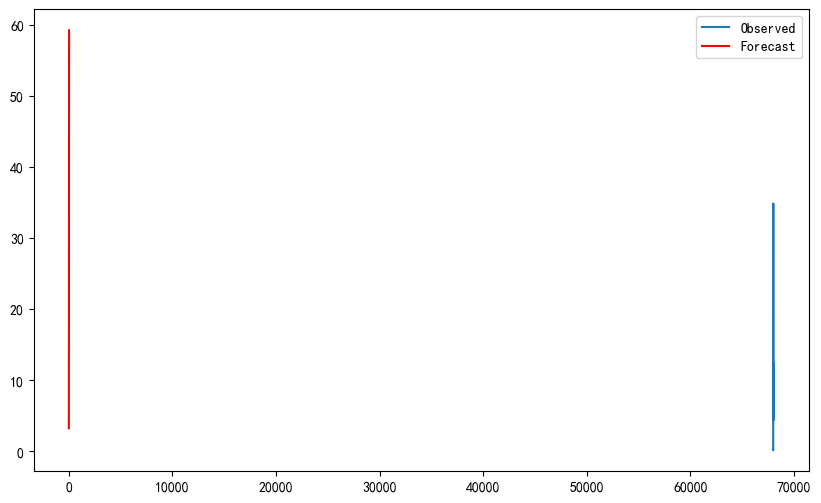

In [61]:
plt.figure(figsize=(10, 6))
plt.plot( target, label='Observed')
plt.plot( predicted_mean, color='red', label='Forecast')
# plt.fill_between(conf_int.iloc[:, 0], conf_int, color='pink')
plt.legend()
plt.show()